<p>&nbsp;</p>

### **Introduction**

<p>&nbsp;</p>

<font size = "4">

The United States Congress is a series of legislative debates, during which, there are a number of topics discussed by politicians. It is believed by political scientists that each congress typically runs around 40-50 or so topics. In this analysis, I will be conducting LDA topic modeling on text data related to the 110th Congress. The 110th Congress took place between 2007 to 2009. The data I will be using consists of all of the captured text from what the politicians discussed during the 110th Congress. It consists of the House of Representatives and does not consist of the Senate.

<p>&nbsp;</p>

In [ ]:
# Import packages
import pandas
import numpy
import re
import os
import bs4
import matplotlib
import seaborn
import nltk
import sklearn
import scipy
import smart_open
import gensim
import pyLDAvis

In [2]:
# Additional imports
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import pyLDAvis.sklearn as LDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

In [3]:
# Additional setup
nltk.download("wordnet")
numpy.random.seed(2018)
stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lilgi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<p>&nbsp;</p>

<font size = "4">

In the following code, I will load the text data. The data comes in the form of a top level folder, with four subfolders, and within each subfolder consists a number of text files associated with individual house speakers. The subfolders are categorized by female democrats, female republicans, male democrats, and male republicans. I will read in the text by iterating through each of the files, using the Beautiful Soup package to parse the text, and then save that in a dataframe.

<p>&nbsp;</p>

In [4]:
# Save the paths for the 4 directories within the 110 directory
dir1 = "110/110-f-d"
dir2 = "110/110-f-r"
dir3 = "110/110-m-d"
dir4 = "110/110-m-r"

In [9]:
# Define a function to load the text files
def load_files(dir):

    # Save the column names for the subsequent dataframe
    columns = ["FileName", "FilePath", "DocNumber", "Text"]

    # Initiate a dataframe called master which will store the data
    master = pandas.DataFrame(columns = columns)

    # Iterate through each file contained in the directory
    for file in os.listdir(dir):

        # Save the file name - will become a col in the df
        file_name = file

        # Save the file path - will become a col in the df
        file_path = dir + "/" + file

        # Initiate a counter to keep track of how many documents there are
        doc_counter = 0

        # Access the contents of the file
        soup = bs4.BeautifulSoup(open(file_path))

        # Iterate through all of the text tags in the html
        for doc in soup.find_all("text"):

            # Retrieve the text and append it to the list
            text = doc.get_text()

            # Save the file name, file path, doc number, and text in a temp dictionary
            temp = {
                "FileName": file_name,
                "FilePath": file_path,
                "DocNumber": doc_counter + 1,
                "Text": text
            }

            # Append the dictionary to the master dataframe
            master = master.append(temp, ignore_index = True)

            # Add one to the counter after each iteration
            doc_counter += 1

    # Return the master dataframe
    return master

In [10]:
# Load the text files
fd = load_files(dir1)   # Female and democrat
fr = load_files(dir2)   # Female and republican
md = load_files(dir3)   # Male and democrat
mr = load_files(dir4)   # Male and republican

In [12]:
# Add columns for the sex and the political party
fd["Sex"] = 0; fd["Party"] = 0
fr["Sex"] = 0; fr["Party"] = 1
md["Sex"] = 1; md["Party"] = 0
mr["Sex"] = 1; mr["Party"] = 1

In [13]:
# Concatenate the data into one large dataframe
congress = pandas.concat([fd, fr, md, mr]).reset_index(drop = True)

<p>&nbsp;</p>

<font size = "4">

Now that the data has been loaded, I will display the first 5 observations of the dataframe, as well as an example of what one of the text documents look liks. I will also take a look at the distribution of the length of each text document.

<p>&nbsp;</p>

In [14]:
# Show the top 5 observations in the dataframe
congress.head(5)

,FileName,FilePath,DocNumber,Text,Sex,Party
0,110_baldwin_x_wi.txt,110/110-f-d/110_baldwin_x_wi.txt,1,"\n Ms. BALDWIN. Mr. Speaker, I yield myself ...",0,0
1,110_baldwin_x_wi.txt,110/110-f-d/110_baldwin_x_wi.txt,2,"\n Ms. BALDWIN. Mr. Speaker, I would also li...",0,0
2,110_baldwin_x_wi.txt,110/110-f-d/110_baldwin_x_wi.txt,3,"\n Ms. BALDWIN. Mr. Speaker, I yield myself ...",0,0
3,110_baldwin_x_wi.txt,110/110-f-d/110_baldwin_x_wi.txt,4,"\n Ms. BALDWIN. Mr. Speaker, the Loving v. V...",0,0
4,110_baldwin_x_wi.txt,110/110-f-d/110_baldwin_x_wi.txt,5,"\n Ms. BALDWIN. Mr. Speaker, the matter befo...",0,0


In [16]:
# Show the text from the first observation
print(congress.Text[0])


   Ms. BALDWIN. Mr. Speaker, I yield myself such time as I may consume. 
   As part of our Nation's bicentennial celebration in 1976, Congress passed a joint resolution re-emphasizing existing rules and customs pertaining to the display and use of the flag, especially recommending its display on a number of different holidays, including Mother's Day, the second Sunday in May. 
   Omitted from the list was Father's Day. H.R. 2356 would amend the Federal flag code to include Father's Day, the third Sunday in June, among important holidays on which to fly the American flag. 
   The law now provides that, in addition to the important occasions listed in the flag code, ``the flag should be displayed on all days.'' I know that this is the custom in every community in the United States. 
   Still, I think that it is important for the flag code to recognize both mothers and fathers, who raise the next generation, inculcate them with the values they need to be good citizens and good neighbors.

                  0
count  40433.000000
mean     465.201568
std      648.661479
min       53.000000
25%      182.000000
50%      314.000000
75%      568.000000
max    17177.000000 



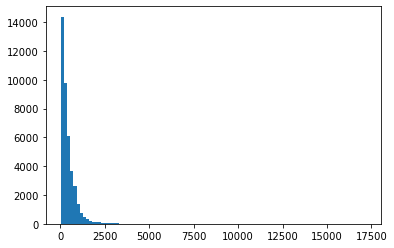

In [17]:
# Show summary statistics and a distribution of the length of text from each file
text_lengths = []
for text in congress.Text:
    tokens = nltk.word_tokenize(text)
    text_lengths.append(len(tokens))
print(pandas.DataFrame(text_lengths).describe(), "\n")
matplotlib.pyplot.hist(text_lengths, bins = 100)
matplotlib.pyplot.show()

<p>&nbsp;</p>

<font size = "4">

There are a large number of text documents - about 40,000. With 429 different individuals from the House of Representatives. That means on average, each representative had about 100 documents or so. The lengths of the documents are pretty closely distributed with some outliers.

In the next section, I will go through the LDA process using the Gensim package. I will first preprocess the text, and then fit the LDA model, followed by using the pyLDAvis package to construct an interactive HTML document that will allow me to further analyze the results form the LDA model.

<p>&nbsp;</p>

In [18]:
# Create a new df with just the text
documents = pandas.DataFrame(
    list(zip(congress.index, congress["Text"])),
    columns = ["Index", "Text"]
)

In [19]:
# Define a function to perform preprocessing
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [20]:
# Preprocess the text, saving the results as "processed_docs"
processed_docs = documents["Text"].map(preprocess)
print(processed_docs[:10])

0    [baldwin, speaker, yield, time, consume, natio...
1    [baldwin, speaker, like, join, gentleman, iowa...
2    [baldwin, speaker, yield, time, consume, speak...
3    [baldwin, speaker, loving, virginia, decision,...
4    [baldwin, speaker, matter, today, iraq, supple...
5    [baldwin, speaker, rise, support, resolution, ...
6    [baldwin, speaker, thank, chairman, filner, ri...
7    [baldwin, speaker, rise, today, colleagues, ho...
8    [baldwin, speaker, thank, chairman, speaker, r...
9    [baldwin, madam, chairman, yield, minutes, mad...
Name: Text, dtype: object


In [38]:
# Create a dictionary from "processed_docs" containing the number of
# times a word appears in the data
dictionary = gensim.corpora.Dictionary(processed_docs)

In [39]:
# Take a look at the first 10 words
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 addition
1 amend
2 american
3 balance
4 baldwin
5 bicentennial
6 celebration
7 citizens
8 code
9 colleague
10 colleagues


In [40]:
# Filter out tokens that appear in less than 15 docs or than .5 docs (fraction of corpus size)
# After the two above steps, keep only the first 100000 most frequent tokens
dictionary.filter_extremes(no_below = 100, no_above = 0.75)

In [42]:
# For each document create a dictionary reporting how many words and how many times the words appear
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [43]:
# Create tf-idf model object using models.TfidfModel on "bow_corpus"
# Save it to "tfidf" then apply transformation to the entire corpus and
# call it "corpus_tfidf". Finally we preview TF-IDF scores for our first document
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf: pprint(doc); break

[(0, 0.057490631559960426),
 (1, 0.08152381440458328),
 (2, 0.02232151319377536),
 (3, 0.03340282020001905),
 (4, 0.11507454591242622),
 (5, 0.09739478633777479),
 (6, 0.05211958212128136),
 (7, 0.3307402588046778),
 (8, 0.04388419975362708),
 (9, 0.023644406927892093),
 (10, 0.04374747122285954),
 (11, 0.020144855453864297),
 (12, 0.045012953801724695),
 (13, 0.11078681889373727),
 (14, 0.05001195573166657),
 (15, 0.0529577467364102),
 (16, 0.2244112361285344),
 (17, 0.1147684591357682),
 (18, 0.04593757610494175),
 (19, 0.09432257873088964),
 (20, 0.05463333940245981),
 (21, 0.06833401660148843),
 (22, 0.14866525871859806),
 (23, 0.17956661304212818),
 (24, 0.033690871565876024),
 (25, 0.6872319128369573),
 (26, 0.06901988603428989),
 (27, 0.025945373069794764),
 (28, 0.05894686354662444),
 (29, 0.05989597890545781),
 (30, 0.10286158990953516),
 (31, 0.07683520604134522),
 (32, 0.05866737536172525),
 (33, 0.04328257499800945),
 (34, 0.0480885911873588),
 (35, 0.08305634002358629),
 (

In [51]:
# Initiate the lda model
lda_model = LdaMulticore(bow_corpus, num_topics = 15, id2word = dictionary, passes = 10)

In [52]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
perplx = lda_model.log_perplexity(bow_corpus)
print('\nPerplexity: ', perplx )


Perplexity:  -7.332847666941751


In [53]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.029*"going" + 0.028*"people" + 0.020*"think" + 0.017*"know" + '
  '0.015*"want" + 0.012*"said" + 0.009*"things" + 0.009*"come" + '
  '0.009*"country" + 0.009*"need"'),
 (1,
  '0.051*"health" + 0.042*"care" + 0.035*"children" + 0.016*"insurance" + '
  '0.015*"program" + 0.012*"medicare" + 0.009*"medical" + 0.008*"speaker" + '
  '0.008*"percent" + 0.008*"schip"'),
 (2,
  '0.009*"economy" + 0.009*"financial" + 0.008*"families" + 0.008*"american" + '
  '0.008*"today" + 0.008*"workers" + 0.007*"credit" + 0.007*"legislation" + '
  '0.007*"market" + 0.007*"speaker"'),
 (3,
  '0.050*"energy" + 0.012*"percent" + 0.012*"prices" + 0.010*"american" + '
  '0.009*"natural" + 0.009*"america" + 0.008*"trade" + 0.008*"world" + '
  '0.008*"fuel" + 0.008*"today"'),
 (4,
  '0.014*"speaker" + 0.011*"veterans" + 0.009*"service" + 0.009*"time" + '
  '0.009*"today" + 0.008*"great" + 0.008*"thank" + 0.008*"honor" + '
  '0.008*"nation" + 0.007*"years"'),
 (5,
  '0.015*"united" + 0.014*"states" + 0.011

In [54]:
# Save a vis to an html document for further interpretation
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "lda_example.html")

<p>&nbsp;</p>

### **Conclusion**

<p>&nbsp;</p>

<font size = "4">

After some trial and error, I found that the best result came from modeling about 20 topics, based on the perplexity score and based on my own judgement in reviewing the topics. When I tried to model 40 topics, there was too much overlap between the topics and I could tell that some words were not put in the right topic. I also tried to model 10 and 15 topics, but I felt like there were not enough topics in this case because some of the topics had words seemed like they could have been further broken down.

Out of the 20 topics, here are the ones that I think are the most distinguished - Spend, Government, Iraq, Socioeconomic, Healthcare, Science, Border Control, Education, and Agriculture. It seemed like the words associated with these topics made the most sense, but some of the other topics I could not come up with a topic. I would be interested to see if there were any real labels that could be found for this dataset, but I do not think they are, which is why this is an unsupervised problem.

<p>&nbsp;</p>